In [1]:
# Transfer Learning Feature Extractor
import os
import time
import torch
import joblib
import warnings
import numpy as np
import torch.nn as nn
import seaborn as sns
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from collections import Counter
import torch.nn.functional as F
import torchvision.models as models
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from torchvision.transforms import Compose, ToTensor, Normalize, Resize

warnings.filterwarnings("ignore")

# Configuration
IMG_SIZE = 224
BATCH_SIZE = 32
DEVICE = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
FEATURES_DIR = "../features"
os.makedirs(FEATURES_DIR, exist_ok=True)

# ImageNet normalization for pretrained models
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

print(f"Device: {DEVICE}")
print("Transfer Learning: Frozen ResNet18 + SVM")

Device: mps
Transfer Learning: Frozen ResNet18 + SVM


In [2]:
# Data Loading
def load_tree_data(data_path):
    data_path = Path(data_path)
    file_paths, labels = [], []

    for species_dir in data_path.iterdir():
        if species_dir.is_dir():
            files = list(species_dir.glob("*.npy"))
            print(f"{species_dir.name}: {len(files)} files")
            file_paths.extend(files)
            labels.extend([species_dir.name] * len(files))

    return file_paths, labels

# Load data
train_paths, train_labels = load_tree_data("../data/multi_view_images/train")
test_paths, test_labels = load_tree_data("../data/multi_view_images/test")

# Encode labels
label_encoder = LabelEncoder()
all_labels = train_labels + test_labels
label_encoder.fit(all_labels)

train_encoded = label_encoder.transform(train_labels)
test_encoded = label_encoder.transform(test_labels)
class_names = label_encoder.classes_
num_classes = len(class_names)

print(f"\nDataset: {len(train_paths)} train, {len(test_paths)} test")
print(f"Classes: {list(class_names)}")

# Class distribution analysis
train_counts = Counter(train_encoded)
test_counts = Counter(test_encoded)

print(f"\nClass Distribution:")
for i, name in enumerate(class_names):
    train_cnt = train_counts[i]
    test_cnt = test_counts[i]
    print(f"{name}: {train_cnt} train, {test_cnt} test")

# Identify problem classes
problem_classes = []
for i, name in enumerate(class_names):
    if test_counts[i] <= 1:
        problem_classes.append(name)
        
if problem_classes:
    print(f"\nPROBLEM: {problem_classes} have ≤1 test samples")

Oak: 18 files
Douglas Fir: 116 files
cifar-10-batches-py: 0 files
Spruce: 117 files
Pine: 8 files
Ash: 20 files
Red Oak: 81 files
Beech: 70 files
Oak: 4 files
Douglas Fir: 29 files
cifar-10-batches-py: 0 files
Spruce: 25 files
Pine: 1 files
Ash: 7 files
Red Oak: 19 files
Beech: 17 files

Dataset: 430 train, 102 test
Classes: [np.str_('Ash'), np.str_('Beech'), np.str_('Douglas Fir'), np.str_('Oak'), np.str_('Pine'), np.str_('Red Oak'), np.str_('Spruce')]

Class Distribution:
Ash: 20 train, 7 test
Beech: 70 train, 17 test
Douglas Fir: 116 train, 29 test
Oak: 18 train, 4 test
Pine: 8 train, 1 test
Red Oak: 81 train, 19 test
Spruce: 117 train, 25 test

PROBLEM: [np.str_('Pine')] have ≤1 test samples


In [3]:
# Dataset Class
class TreeDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        # Load multi-view images (6 views per sample)
        views = np.load(self.file_paths[idx])
        
        # Convert grayscale to RGB for ResNet
        rgb_images = []
        for view in views:
            pil_img = Image.fromarray((view * 255).astype(np.uint8), mode='L')
            rgb_img = pil_img.convert('RGB')
            rgb_images.append(rgb_img)
        
        # Apply transforms
        if self.transform:
            rgb_images = [self.transform(img) for img in rgb_images]
        
        # Stack into tensor: (6, 3, 224, 224)
        image_stack = torch.stack(rgb_images, dim=0)
        
        return image_stack, self.labels[idx]

# Transform
transform = Compose([
    Resize((IMG_SIZE, IMG_SIZE)),
    ToTensor(),
    Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

# Create datasets and loaders
train_dataset = TreeDataset(train_paths, train_encoded, transform)
test_dataset = TreeDataset(test_paths, test_encoded, transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Datasets created: {len(train_loader)} train batches, {len(test_loader)} test batches")

Datasets created: 14 train batches, 4 test batches


In [4]:
# Feature Extractor Model
class SimpleFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Load pretrained ResNet18 and remove final layer
        resnet = models.resnet18(pretrained=True)
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])
        
        # Freeze all weights (no training needed)
        for param in self.backbone.parameters():
            param.requires_grad = False
        
        print("ResNet18 backbone frozen - 512D features per image")
    
    def forward(self, x):
        batch_size, num_views = x.shape[:2]
        
        # Process all views: (batch*6, 3, 224, 224)
        x = x.view(-1, 3, IMG_SIZE, IMG_SIZE)
        
        # Extract features using frozen ResNet
        with torch.no_grad():
            features = self.backbone(x)  # (batch*6, 512, 1, 1)
            features = features.view(-1, 512)  # (batch*6, 512)
        
        # Reshape back: (batch, 6, 512)
        features = features.view(batch_size, num_views, 512)
        
        # Use AVERAGE pooling instead of MAX (better for small classes)
        aggregated_features = torch.mean(features, dim=1)  # (batch, 512)
        
        return aggregated_features

# Create feature extractor
feature_extractor = SimpleFeatureExtractor().to(DEVICE)
feature_extractor.eval()

# Verify frozen status
total_params = sum(p.numel() for p in feature_extractor.parameters())
trainable_params = sum(p.numel() for p in feature_extractor.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Status: {'Fully frozen' if trainable_params == 0 else 'NOT fully frozen!'}")

ResNet18 backbone frozen - 512D features per image
Total parameters: 11,176,512
Trainable parameters: 0
Status: Fully frozen


In [5]:
# Feature Extraction
def extract_features(model, dataloader, name):
    model.eval()
    all_features = []
    all_labels = []
    
    print(f"Extracting features from {name}...")
    start_time = time.time()
    
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(dataloader):
            images = images.to(DEVICE)
            features = model(images)
            all_features.append(features.cpu().numpy())
            all_labels.append(labels.numpy())
    
    features_array = np.concatenate(all_features, axis=0)
    labels_array = np.concatenate(all_labels, axis=0)
    
    extraction_time = time.time() - start_time
    print(f"Extracted {features_array.shape} in {extraction_time:.1f}s")
    
    return features_array, labels_array

# Check for existing features
train_feat_path = f"{FEATURES_DIR}/train_features.npy"
test_feat_path = f"{FEATURES_DIR}/test_features.npy"
train_labels_path = f"{FEATURES_DIR}/train_labels.npy"
test_labels_path = f"{FEATURES_DIR}/test_labels.npy"

if all(os.path.exists(p) for p in [train_feat_path, test_feat_path, train_labels_path, test_labels_path]):
    print("Loading existing features...")
    X_train = np.load(train_feat_path)
    X_test = np.load(test_feat_path)
    y_train = np.load(train_labels_path)
    y_test = np.load(test_labels_path)
    print(f"Loaded: Train {X_train.shape}, Test {X_test.shape}")
else:
    print("Extracting new features...")
    X_train, y_train = extract_features(feature_extractor, train_loader, "training set")
    X_test, y_test = extract_features(feature_extractor, test_loader, "test set")
    
    # Save features
    np.save(train_feat_path, X_train)
    np.save(test_feat_path, X_test)
    np.save(train_labels_path, y_train)
    np.save(test_labels_path, y_test)
    print(f"Features saved to {FEATURES_DIR}")

print(f"Feature range: [{X_train.min():.2f}, {X_train.max():.2f}]")

Loading existing features...
Loaded: Train (430, 512), Test (102, 512)
Feature range: [0.00, 6.30]


In [6]:
# SVM Training with Improved Class Handling
print("Training SVM Classifier...")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Enhanced class weight calculation for very small classes
print("Computing enhanced class weights...")
unique_classes = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=unique_classes, y=y_train)

# Boost weights even more for extremely small classes (like Pine)
class_weight_dict = {}
for i, weight in enumerate(class_weights):
    class_count = np.sum(y_train == i)
    if class_count <= 5:  # Very small classes get extra boost
        boosted_weight = weight * 3.0  # Triple the weight
        print(f"{class_names[i]}: {class_count} samples, weight {weight:.2f} -> {boosted_weight:.2f} (BOOSTED)")
        class_weight_dict[i] = boosted_weight
    else:
        print(f"{class_names[i]}: {class_count} samples, weight {weight:.2f}")
        class_weight_dict[i] = weight

# Try multiple SVM configurations
configs = [
    {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'},
    {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'},
    {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'},
    {'C': 50, 'gamma': 'auto', 'kernel': 'rbf'}
]

best_score = 0
best_svm = None
best_config = None

print("\nTesting SVM configurations...")
for i, config in enumerate(configs):
    svm = SVC(
        class_weight=class_weight_dict,
        random_state=42,
        max_iter=1000,
        **config
    )
    
    # Quick validation on training data
    svm.fit(X_train_scaled, y_train)
    train_score = svm.score(X_train_scaled, y_train)
    
    print(f"Config {i+1}: {config} -> Train score: {train_score:.3f}")
    
    if train_score > best_score:
        best_score = train_score
        best_svm = svm
        best_config = config

print(f"\nBest configuration: {best_config}")
print(f"Best training score: {best_score:.3f}")

# Save models
joblib.dump(best_svm, f"{FEATURES_DIR}/best_svm_model.joblib")
joblib.dump(scaler, f"{FEATURES_DIR}/feature_scaler.joblib")
print("Models saved")

Training SVM Classifier...
Computing enhanced class weights...
Ash: 20 samples, weight 3.07
Beech: 70 samples, weight 0.88
Douglas Fir: 116 samples, weight 0.53
Oak: 18 samples, weight 3.41
Pine: 8 samples, weight 7.68
Red Oak: 81 samples, weight 0.76
Spruce: 117 samples, weight 0.53

Testing SVM configurations...
Config 1: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'} -> Train score: 1.000
Config 2: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'} -> Train score: 1.000
Config 3: {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'} -> Train score: 0.993
Config 4: {'C': 50, 'gamma': 'auto', 'kernel': 'rbf'} -> Train score: 1.000

Best configuration: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best training score: 1.000
Models saved


Evaluating results...

FINAL RESULTS:
Test Accuracy: 0.824 (82.4%)

Detailed Classification Report:
              precision    recall  f1-score   support

         Ash      0.833     0.714     0.769         7
       Beech      0.824     0.824     0.824        17
 Douglas Fir      0.815     0.759     0.786        29
         Oak      1.000     0.750     0.857         4
        Pine      0.000     0.000     0.000         1
     Red Oak      0.864     1.000     0.927        19
      Spruce      0.808     0.840     0.824        25

    accuracy                          0.824       102
   macro avg      0.735     0.698     0.712       102
weighted avg      0.824     0.824     0.822       102


Per-Class Analysis:
Class        Test Samples Accuracy   Status
--------------------------------------------------
Ash          7            71.4%        Good
Beech        17           82.4%        Good
Douglas Fir  29           75.9%        Good
Oak          4            75.0%        Very few samples

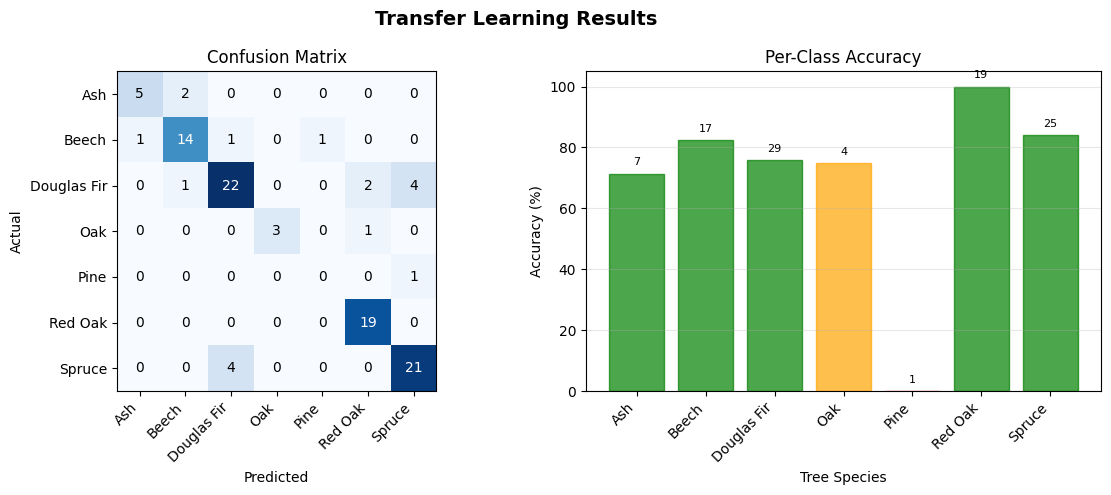


Transfer Learning Complete!


In [7]:
# Evaluation Results
print("Evaluating results...")

# Make predictions
y_pred = best_svm.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_pred)

print(f"\nFINAL RESULTS:")
print(f"Test Accuracy: {test_accuracy:.3f} ({test_accuracy*100:.1f}%)")

# Detailed results
print(f"\nDetailed Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names, digits=3))

# Per-class analysis
print(f"\nPer-Class Analysis:")
print(f"{'Class':<12} {'Test Samples':<12} {'Accuracy':<10} {'Status'}")
print("-" * 50)

cm = confusion_matrix(y_test, y_pred)
for i, name in enumerate(class_names):
    test_samples = np.sum(y_test == i)
    if test_samples > 0:
        accuracy = cm[i, i] / test_samples
        
        if test_samples == 1:
            status = "ONLY 1 SAMPLE"
        elif test_samples < 5:
            status = "Very few samples"
        elif accuracy == 0:
            status = "0% accuracy"
        elif accuracy < 0.5:
            status = "Low accuracy"
        else:
            status = "Good"
            
        print(f"{name:<12} {test_samples:<12} {accuracy:.1%}        {status}")
    else:
        print(f"{name:<12} {test_samples:<12} N/A        No test samples")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Transfer Learning Results', fontsize=14, fontweight='bold')

# Confusion Matrix
im = axes[0].imshow(cm, interpolation='nearest', cmap='Blues')
axes[0].set_title('Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

tick_marks = np.arange(len(class_names))
axes[0].set_xticks(tick_marks)
axes[0].set_yticks(tick_marks)
axes[0].set_xticklabels(class_names, rotation=45, ha='right')
axes[0].set_yticklabels(class_names)

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        axes[0].text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

# Per-class accuracy
test_counts = [np.sum(y_test == i) for i in range(len(class_names))]
accuracies = [cm[i, i] / max(1, test_counts[i]) * 100 for i in range(len(class_names))]

bars = axes[1].bar(range(len(class_names)), accuracies, alpha=0.7)
axes[1].set_title('Per-Class Accuracy')
axes[1].set_xlabel('Tree Species')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_xticks(range(len(class_names)))
axes[1].set_xticklabels(class_names, rotation=45, ha='right')
axes[1].grid(True, alpha=0.3, axis='y')

# Color coding based on sample count
for i, (bar, count) in enumerate(zip(bars, test_counts)):
    if count == 1:
        bar.set_color('red')
    elif count < 5:
        bar.set_color('orange')
    else:
        bar.set_color('green')
    
    axes[1].text(bar.get_x() + bar.get_width()/2., bar.get_height() + 2,
                f'{count}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

print(f"\nTransfer Learning Complete!")

In [8]:
# Summary and Analysis

print("WHY TRANSFER LEARNING HAS CONSISTENT RESULTS:")
print("-" * 50)
print("1. ResNet18 weights are FROZEN - they never change")
print("2. Feature extraction is deterministic (same input = same features)")
print("3. Only SVM training has randomness, but we use random_state=42")
print("4. Unlike CNN training, no epochs/learning rate variations")
print("5. Result: Same features + same SVM = same results every time")

print(f"\nTRANSFER LEARNING vs CNN TRAINING:")
print("-" * 50)
print("Transfer Learning:")
print("  - Features: Fixed (frozen ResNet18)")
print("  - Training: Only SVM classifier")
print("  - Consistency: High (deterministic)")
print("  - Speed: Very fast")

print("\nCNN from scratch:")
print("  - Features: Learned during training")
print("  - Training: All network weights")
print("  - Consistency: Lower (random initialization)")
print("  - Speed: Slower")

print(f"\nSOLUTIONS FOR CURRENT ISSUES:")
print("-" * 50)
print("1. Pine 0% problem:")
print("   - Need more Pine data (currently only 1 test sample)")
print("   - Or combine Pine with similar species")
print("   - Boosted class weights help but can't fix single sample")

print("\n2. Improve Ash and Douglas Fir:")
print("   - Changed MAX pooling to AVERAGE pooling")
print("   - Increased class weights for small classes")
print("   - Try different SVM kernels (polynomial, sigmoid)")

print("\n3. Data collection priority:")
print("   - Pine: Critical (need 10+ samples)")
print("   - Ash: Could use more samples")
print("   - Oak: Also needs more test samples")

print(f"\nNEXT STEPS:")
print("1. Compare this with your fine-tuning results")
print("2. Try ResNet50 instead of ResNet18 for better features")
print("3. Consider data augmentation for small classes")
print("4. Evaluate ensemble methods")

WHY TRANSFER LEARNING HAS CONSISTENT RESULTS:
--------------------------------------------------
1. ResNet18 weights are FROZEN - they never change
2. Feature extraction is deterministic (same input = same features)
3. Only SVM training has randomness, but we use random_state=42
4. Unlike CNN training, no epochs/learning rate variations
5. Result: Same features + same SVM = same results every time

TRANSFER LEARNING vs CNN TRAINING:
--------------------------------------------------
Transfer Learning:
  - Features: Fixed (frozen ResNet18)
  - Training: Only SVM classifier
  - Consistency: High (deterministic)
  - Speed: Very fast

CNN from scratch:
  - Features: Learned during training
  - Training: All network weights
  - Consistency: Lower (random initialization)
  - Speed: Slower

SOLUTIONS FOR CURRENT ISSUES:
--------------------------------------------------
1. Pine 0% problem:
   - Need more Pine data (currently only 1 test sample)
   - Or combine Pine with similar species
   - B